$V(x)=\sum_{t=1}^T R(x(t))$ \
where  $R(x)=-\|x-x_{goal}\|-variance$ \
and $T=15$

Use all datas 

# Create Environment

In [30]:
import numpy as np
import matplotlib.pylab as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from tqdm import tqdm

global N

N=50

global M
M=10

global T
global target
T=10
target=np.array([3,2])
global w
w=np.pi*2/23.7

global delta_t
delta_t=T/N

global beta
beta=[0.95,0.975,1,1.025,1.05]

global num_system
num_system=5

global num_action
num_action=8

global obs_para
obs_para=6

global coeff
coeff=[]
for i in range(N+1):
    coeff.append(0.2**(N-i))
print(coeff)

[1.1258999068426271e-35, 5.629499534213136e-35, 2.8147497671065676e-34, 1.4073748835532837e-33, 7.036874417766418e-33, 3.5184372088832087e-32, 1.7592186044416043e-31, 8.796093022208022e-31, 4.39804651110401e-30, 2.199023255552005e-29, 1.0995116277760024e-28, 5.497558138880012e-28, 2.7487790694400056e-27, 1.374389534720003e-26, 6.871947673600013e-26, 3.4359738368000065e-25, 1.717986918400003e-24, 8.589934592000015e-24, 4.294967296000008e-23, 2.1474836480000035e-22, 1.0737418240000018e-21, 5.368709120000009e-21, 2.684354560000004e-20, 1.342177280000002e-19, 6.71088640000001e-19, 3.3554432000000048e-18, 1.6777216000000023e-17, 8.388608000000011e-17, 4.194304000000005e-16, 2.0971520000000026e-15, 1.0485760000000012e-14, 5.2428800000000056e-14, 2.6214400000000027e-13, 1.3107200000000013e-12, 6.5536000000000055e-12, 3.276800000000003e-11, 1.6384000000000013e-10, 8.192000000000005e-10, 4.096000000000002e-09, 2.0480000000000012e-08, 1.0240000000000006e-07, 5.120000000000002e-07, 2.560000000000

In [31]:
def Z(vecs, u, v):
    output=[]
    for i in range(num_system):
        vec=vecs[i]
        x=vec[0]
        y=vec[1]
        theta=vec[2]
        output.append([beta[i]*np.cos(theta)*u,beta[i]*np.sin(theta)*u,beta[i]*v])
    return np.array(output)

#check the correctness of Z
'''
x = np.linspace(0, 6.5, 1001)
plt.plot(x, Z(x))
plt.xlabel('Angle [rad]')
plt.ylabel('Z(theta)')
plt.grid()
plt.show()
'''

"\nx = np.linspace(0, 6.5, 1001)\nplt.plot(x, Z(x))\nplt.xlabel('Angle [rad]')\nplt.ylabel('Z(theta)')\nplt.grid()\nplt.show()\n"

In [32]:
def next_step(vecs,action):  
    u=action[0]
    v=action[1]
   
    for j in range(M):
        vecs_new=[]
        diff=Z(vecs,u,v)
        for i in range(num_system):
            w=vecs[i]+delta_t/M*diff[i]
            '''
            if w[2]>np.pi:
                w[2]-=2*np.pi
            if w[2]<-np.pi:
                w[2]+=2*np.pi
            '''
            vecs_new.append(w)
        vecs=np.array(vecs_new)
    return vecs

def observe(vecs):
    mu_x=0
    mu_y=0
    mu_theta=0
    var_x=0
    var_y=0
    var_theta=0
    for i in range(num_system):
        mu_x+=vecs[i][0]
        mu_y+=vecs[i][1]
        mu_theta+=vecs[i][2]
        var_x+=vecs[i][0]**2
        var_y+=vecs[i][1]**2
        var_theta+=vecs[i][2]**2
    var_x-=mu_x**2/num_system
    var_y-=mu_y**2/num_system
    var_theta-=mu_theta**2/num_system
    
    w=np.array([mu_x,mu_y,mu_theta,var_x,var_y,var_theta])/num_system
    if w[2]>np.pi:
        w[2]-=2*np.pi
    if w[2]<-np.pi:
        w[2]+=2*np.pi
    return w

def reward(obs):
    return max(10-np.sqrt((obs[0]-target[0])**2+(obs[1]-target[1])**2)-10*obs[3]-10*obs[4],0)

def reward_raw(position):
    r=0
    for i in range(num_system):
        r+=np.linalg.norm(position[i,[0,1]]-target)
    return r

def value_func(funcs,flags,next_state):
    result=[]
    for i in range(6):
        if flags[i]:
            result.append(0)
        else:
            k,_=funcs[i].predict(next_state.reshape(-1,obs_para), return_std=True)
            result.append(k[0])
    result=np.array(result)
    return np.max(result)

# Learning Settings

In [33]:
global lr
lr=0.01
global eps
eps=0.05
global max_u
max_u=2
global precision
precision=0.0002
global action_set
action_set=np.array([[1,np.pi/2],[-1,np.pi/2],[1,np.pi/4],[-1,np.pi/4],[1,0],[-1,0],[1,-np.pi/4],[-1,-np.pi/4],[1,-np.pi/2],[-1,-np.pi/2]])

def exploration():
    a=np.random.uniform()
    if a<eps:
        return True
    else:
        return False

def find_max(cand):
    return np.argmax(cand)
    
def decide_u(funcs,flags,state,init=False):
    explo=exploration()
    if init or explo:
        return np.random.randint(num_action)
    else:
        result=[]
        for i in range(num_action):
            if flags[i]:
                return i
            else:
                k,_=funcs[i].predict(state.reshape(-1,obs_para), return_std=True)
                result.append(k[0])
    result=np.array(result)
    return np.argmax(result)
    
def decide_u_exploitation(funcs,flags,state,init=False):
    result=[]
    for i in range(num_action):
        if flags[i]:
            print("Err",i)
            return i
        else:
            k,_=funcs[i].predict(state.reshape(-1,obs_para), return_std=True)
            result.append(k[0])
    result=np.array(result)
    return np.argmax(result)

history_su=[0 for i in range(num_action)]
history_r=[0 for i in range(num_action)]
history_su_next=[0 for i in range(num_action)]
flags=[True for i in range(num_action)]

history_rt=[[[] for i in range(num_action)] for j in range(N+1)]
history_sut=[[[] for i in range(num_action)] for j in range(N+1)]
flags_t=[[True for i in range(num_action)] for j in range(N+1)]

# Simulation


In [34]:
num_iter=80

position_result=[]
observation_result=[]
gpr_list=[[0 for i in range(num_action)] for j in range(N+1)]

best_r=-10000
best_obs=[]
best_pos=[[] for i in range(num_system)]
best_u=[]

for iterr in tqdm(range(num_iter)):
    #initialize
    position=np.array([[-2,-2,np.pi/2] for _ in range(num_system)])
    observation=observe(position)
    u_t=[]
    r_t=[]
    observation_t=[observation]
    position_t=[[] for i in range(num_system)]
    
    
    history_target=[0 for i in range(num_action)]
    
    '''
    coeff=[]
    for i in range(N):
        coeff.append((np.random.random()-0.5)/100+0.8**(N-i))
    coeff.append(1)
    #print(coeff)
    '''
    
    for time in range(N+1):
        if iterr<5:
            #candidates_u=[]
            u_k = decide_u(gpr_list[time],flags,observation,init=True)
            position_new = next_step(position,action_set[u_k])
            observation_new = observe(position_new)
            r = reward(observation_new)
            r_t.append(r)
            
            if flags[u_k]:
                history_su[u_k] = observation.reshape(-1,obs_para)
                history_su_next[u_k] = observation_new.reshape(-1,obs_para)  
                history_r[u_k] = np.array([r])
                flags[u_k]=False
            else:
                history_su[u_k] = np.concatenate((history_su[u_k], observation.reshape(-1,obs_para)))
                history_su_next[u_k] = np.concatenate((history_su_next[u_k], observation_new.reshape(-1,obs_para)))
                history_r[u_k] = np.concatenate((history_r[u_k],np.array([r])))
            
            
            observation=observation_new
            position=position_new
            u_t.append(u_k)
            observation_t.append(observation)
            for i in range(num_system):
                position_t[i].append(position[i])
            
            
        else:
            #candidates_u=[]
            u_k = decide_u(gpr_list[time],flags,observation)
            #print(candidates_u)
            #u_k, explo = decide_u(observation,np.array(candidates_u))
            
            position_new = next_step(position,action_set[u_k])
            observation_new = observe(position_new)
            r = reward(observation_new)
            r_t.append(r)
            
            history_su[u_k] = np.concatenate((history_su[u_k], observation.reshape(-1,obs_para)))
            history_r[u_k] = np.concatenate((history_r[u_k],np.array([r])))
            history_su_next[u_k] = np.concatenate((history_su_next[u_k], observation_new.reshape(-1,obs_para)))
            
            observation=observation_new
            position=position_new
            u_t.append(u_k)
            observation_t.append(observation)
            for i in range(num_system):
                position_t[i].append(position[i])
            
            
            
            
    #update
    #calculate cumulative r 
    

    '''
    for j in range(6):
        history_target[j]=last_coeff*history_r[u_t[-i]]
        gpr_list[-i][j]=GaussianProcessRegressor(alpha=1e-4).fit(history_su[j], history_target[j])
    '''  
         
    #TODO
       
    for i in range(N+1):
        if i==1:
            for j in range(num_action):
                history_target[j]=coeff[-1]*history_r[j]
                gpr_list[-i][j]=GaussianProcessRegressor(alpha=1e-6).fit(np.array(history_su[j]).reshape(-1,obs_para), history_target[j].reshape(-1,1))
            
        elif i>1:
            for j in range(num_action):
                history_tar=[]
                for k in range(history_r[j].shape[0]):
                    history_tar.append(coeff[N+1-i]*history_r[j][k]+value_func(gpr_list[-i+1],flags_t[-i+1],history_su_next[j][k]))
                gpr_list[-i][j]=GaussianProcessRegressor(alpha=1e-6).fit(np.array(history_su[j]).reshape(-1,obs_para), np.array(history_tar).reshape(-1,1))
            '''
            r_t[-i]=0.5**(N+1-i)*r_t[-i]+value_func(gpr_list[-i+1],flags_t[-i+1],observation_t[-i+1])
            history_rt[-i][u_t[-i]].append(r_t[-i])
            history_sut[-i][u_t[-i]].append(observation_t[-i])
            gpr_list[-i][u_t[-i]]=GaussianProcessRegressor(alpha=1e-4).fit(np.array(history_sut[-i][u_t[-i]]).reshape(-1,5), np.array(history_rt[-i][u_t[-i]]).reshape(-1,1))
            if flags_t[-i][u_t[-i]]:
                flags_t[-i][u_t[-i]]=False
            '''
    for j in range(num_action):
        history_tar=[]
        for k in range(history_r[j].shape[0]):
            history_tar.append(coeff[0]*history_r[j][k]+value_func(gpr_list[1],flags_t[1],history_su_next[j][k]))
        gpr_list[0][j]=GaussianProcessRegressor(alpha=1e-6).fit(np.array(history_su[j]).reshape(-1,obs_para), np.array(history_tar).reshape(-1,1))

            
        
    print("observation =",observation)
    #print(observation_t)
    position_result.append(position)
    observation_result.append(observation)
    if r>best_r:
        best_r=r
        best_obs=observation_t
        best_pos=position_t
        best_u=u_t
    
    #print(history_su.shape)
    #print(u_t)

  1%|█                                                                                  | 1/80 [00:00<01:17,  1.02it/s]

observation = [-2.99961722 -1.58934519  0.31415927  0.01260091  0.04241606  0.03158273]


  2%|██                                                                                 | 2/80 [00:01<01:17,  1.01it/s]

observation = [-6.49188974e-01 -1.91600285e+00 -2.35619449e+00  3.96085164e-05
  1.05942777e-02  6.93956559e-03]


  4%|███                                                                                | 3/80 [00:03<01:18,  1.02s/it]

observation = [-3.54949917e+00 -1.57721761e+00 -9.42477796e-01  8.55930940e-05
  1.87455158e-03  1.77652879e-02]


  5%|████▏                                                                              | 4/80 [00:04<01:20,  1.05s/it]

observation = [-1.19548137e+00 -3.30050503e+00 -7.85398163e-01  1.98317772e-02
  8.49328706e-05  1.92765711e-02]


  6%|█████▏                                                                             | 5/80 [00:05<01:21,  1.08s/it]

observation = [-1.89659980e+00 -1.38068448e+00 -2.98451302e+00  3.68470954e-05
  5.14697640e-04  3.73194416e-03]


  8%|██████▏                                                                            | 6/80 [00:06<01:28,  1.19s/it]

observation = [-1.78428344e+00 -1.55698936e+00  2.67035376e+00  5.55645144e-05
  8.96858494e-04  1.51128317e-03]


  9%|███████▎                                                                           | 7/80 [00:08<01:33,  1.28s/it]

observation = [-2.38861397e+00 -7.01808678e-01 -4.71238898e-01  5.21817053e-04
  8.57918395e-03  5.21238482e-03]


 10%|████████▎                                                                          | 8/80 [00:09<01:37,  1.36s/it]

observation = [ 2.46797594  3.71492876 -2.35619449  0.57316942  0.05810297  0.01927657]


 11%|█████████▎                                                                         | 9/80 [00:11<01:42,  1.45s/it]

observation = [ 2.94543978e+00 -1.76004301e+00  1.41371669e+00  2.00750614e-03
  2.91744192e-01  5.18462656e-02]


 12%|██████████▎                                                                       | 10/80 [00:12<01:44,  1.49s/it]

observation = [ 3.78674461  2.40065531 -2.67035376  0.38981026  0.19342553  0.02248419]


 14%|███████████▎                                                                      | 11/80 [00:15<01:57,  1.70s/it]

observation = [ 2.90282407  2.0210897  -2.67035376  0.20233072  0.11477607  0.02248419]


 15%|████████████▎                                                                     | 12/80 [00:17<02:10,  1.93s/it]

observation = [ 2.20374957  4.29743521 -2.82743339  0.55050902  0.0412083   0.02418053]


 16%|█████████████▎                                                                    | 13/80 [00:20<02:21,  2.12s/it]

observation = [ 2.06830672  3.96593027 -2.82743339  0.45250515  0.02923716  0.02418053]


 18%|██████████████▎                                                                   | 14/80 [00:22<02:30,  2.28s/it]

observation = [ 1.16619093  1.55456009 -3.14159265  0.05863148  0.01958508  0.02775826]


 19%|███████████████▍                                                                  | 15/80 [00:25<02:39,  2.45s/it]

observation = [ 1.24986474  2.10916566 -2.51327412  0.11771159  0.00474977  0.02084954]


 20%|████████████████▍                                                                 | 16/80 [00:28<02:47,  2.62s/it]

observation = [1.00317074 0.90904629 2.51327412 0.04418225 0.00771453 0.03565395]


 21%|█████████████████▍                                                                | 17/80 [00:31<02:54,  2.77s/it]

observation = [ 1.60407357e+00  2.93472055e+00 -1.88495559e+00  2.43811700e-01
  8.32030558e-04  1.49277767e-02]


 22%|██████████████████▍                                                               | 18/80 [00:35<03:03,  2.96s/it]

observation = [ 0.76022557  2.64109411 -1.25663706  0.09754434  0.00948567  0.00999297]


 24%|███████████████████▍                                                              | 19/80 [00:38<03:09,  3.11s/it]

observation = [1.71148815 1.47489291 2.67035376 0.16976168 0.08054349 0.0335875 ]


 25%|████████████████████▌                                                             | 20/80 [00:42<03:15,  3.26s/it]

observation = [ 4.04715595e-01  1.40355142e+00 -1.57079633e+00  1.35245647e-01
  1.32876221e-03  1.23370055e-02]


 26%|█████████████████████▌                                                            | 21/80 [00:46<03:27,  3.52s/it]

observation = [ 4.27331007  2.18428377 -2.98451302  0.39933582  0.38925537  0.02593855]


 28%|██████████████████████▌                                                           | 22/80 [00:50<03:34,  3.70s/it]

observation = [ 2.52041361  1.7561579  -2.82743339  0.27096123  0.10957802  0.02418053]


 29%|███████████████████████▌                                                          | 23/80 [00:54<03:44,  3.94s/it]

observation = [ 1.39934335e+00  2.11674317e+00 -2.19911486e+00  1.70317063e-01
  8.47878671e-04  1.77652879e-02]


 30%|████████████████████████▌                                                         | 24/80 [00:59<03:53,  4.17s/it]

observation = [ 1.17374180e+00  1.48368684e+00 -1.88495559e+00  4.67937754e-02
  1.34591405e-04  1.49277767e-02]


 31%|█████████████████████████▋                                                        | 25/80 [01:04<04:02,  4.41s/it]

observation = [ 4.25750114e-01  8.26446050e-01 -4.71238898e-01  5.33265322e-02
  6.64510685e-04  5.21238482e-03]


 32%|██████████████████████████▋                                                       | 26/80 [01:09<04:12,  4.68s/it]

observation = [ 1.49063010e+00  1.20034228e+00 -1.41371669e+00  3.28189228e-02
  8.97299623e-04  1.11341475e-02]


 34%|███████████████████████████▋                                                      | 27/80 [01:15<04:25,  5.02s/it]

observation = [ 1.84812495e+00  2.48686194e+00 -1.72787596e+00  1.37083043e-01
  2.06878879e-04  1.36015486e-02]


 35%|████████████████████████████▋                                                     | 28/80 [01:21<04:40,  5.39s/it]

observation = [ 1.53803081e+00  1.33086243e+00 -9.42477796e-01  4.70384941e-02
  1.51702872e-04  7.89568352e-03]


 36%|█████████████████████████████▋                                                    | 29/80 [01:28<04:50,  5.70s/it]

observation = [ 1.2446649   0.28985681 -0.4712389   0.04228979  0.00153122  0.00521238]


 38%|██████████████████████████████▊                                                   | 30/80 [01:35<05:01,  6.03s/it]

observation = [ 1.83798331e+00  8.89087045e-01 -7.85398163e-01  4.92371940e-02
  1.59282787e-03  6.93956559e-03]


 39%|███████████████████████████████▊                                                  | 31/80 [01:42<05:12,  6.37s/it]

observation = [ 1.86931833  0.6498749  -0.9424778   0.04473568  0.00288772  0.00789568]


 40%|████████████████████████████████▊                                                 | 32/80 [01:49<05:23,  6.74s/it]

observation = [ 1.09493289  0.14242593 -1.09955743  0.03377671  0.0028909   0.00891349]


 41%|█████████████████████████████████▊                                                | 33/80 [01:57<05:32,  7.07s/it]

observation = [ 1.98765165  0.24148058 -0.62831853  0.04043987  0.00766711  0.00604513]


 42%|██████████████████████████████████▊                                               | 34/80 [02:06<05:43,  7.46s/it]

observation = [ 1.82043068 -0.22281515 -0.4712389   0.02712578  0.0150936   0.00521238]


 44%|███████████████████████████████████▉                                              | 35/80 [02:14<05:50,  7.78s/it]

observation = [ 2.25508752  0.20947426 -0.31415927  0.03993196  0.0106      0.00444132]


 45%|████████████████████████████████████▉                                             | 36/80 [02:23<06:01,  8.22s/it]

observation = [ 1.950161    0.42019407 -0.31415927  0.04286744  0.00516791  0.00444132]


 46%|█████████████████████████████████████▉                                            | 37/80 [02:33<06:11,  8.64s/it]

observation = [ 2.30511532  0.61342612 -0.4712389   0.05172985  0.00612522  0.00521238]


 48%|██████████████████████████████████████▉                                           | 38/80 [02:43<06:19,  9.03s/it]

observation = [ 2.19382939  0.77652827 -0.4712389   0.0505667   0.00386394  0.00521238]


 49%|███████████████████████████████████████▉                                          | 39/80 [02:54<06:28,  9.47s/it]

observation = [ 2.23128696e+00  1.05948029e+00 -4.71238898e-01  5.97293981e-02
  2.21860889e-03  5.21238482e-03]


 50%|█████████████████████████████████████████                                         | 40/80 [03:04<06:36,  9.90s/it]

observation = [ 2.49805964  0.71830292 -0.15707963  0.05119258  0.00734841  0.00373194]


 51%|██████████████████████████████████████████                                        | 41/80 [03:16<06:44, 10.37s/it]

observation = [ 2.23362758  0.78621187 -0.15707963  0.05274366  0.0040482   0.00373194]


 52%|███████████████████████████████████████████                                       | 42/80 [03:28<06:54, 10.91s/it]

observation = [ 1.95944137e+00  1.42013927e+00 -1.09955743e+00  6.91400573e-02
  1.19102752e-04  8.91348647e-03]


 54%|████████████████████████████████████████████                                      | 43/80 [03:40<06:58, 11.32s/it]

observation = [ 2.53717167e+00  1.23941758e+00 -4.71238898e-01  6.70048334e-02
  2.51894407e-03  5.21238482e-03]


 55%|█████████████████████████████████████████████                                     | 44/80 [03:53<07:02, 11.73s/it]

observation = [ 2.8651897   1.01506934 -0.31415927  0.06410547  0.00717811  0.00444132]


 56%|██████████████████████████████████████████████▏                                   | 45/80 [04:06<07:08, 12.25s/it]

observation = [ 2.48166686  1.05628566 -0.15707963  0.05904139  0.00363408  0.00373194]


 57%|███████████████████████████████████████████████▏                                  | 46/80 [04:20<07:10, 12.67s/it]

observation = [ 2.61832206  1.32717561 -0.31415927  0.06049362  0.0030658   0.00444132]


 59%|████████████████████████████████████████████████▏                                 | 47/80 [04:34<07:07, 12.97s/it]

observation = [ 2.78747243e+00  1.43743567e+00 -3.14159265e-01  7.20876324e-02
  2.69402335e-03  4.44132198e-03]


 60%|█████████████████████████████████████████████████▏                                | 48/80 [04:49<07:14, 13.58s/it]

observation = [ 2.77751400e+00  1.47595935e+00 -1.57079633e-01  7.26911726e-02
  2.39287995e-03  3.73194416e-03]


 61%|██████████████████████████████████████████████████▏                               | 49/80 [05:04<07:13, 13.99s/it]

observation = [ 2.81139598  1.31358126 -0.31415927  0.0697675   0.00379262  0.00444132]


 62%|███████████████████████████████████████████████████▎                              | 50/80 [05:19<07:13, 14.44s/it]

observation = [ 2.77674728e+00  1.74074169e+00 -6.28318531e-01  8.06944509e-02
  9.41354869e-04  6.04513270e-03]


 64%|████████████████████████████████████████████████████▎                             | 51/80 [05:35<07:13, 14.93s/it]

observation = [3.04887584e+00 1.52571774e+00 1.57079633e-01 7.46584764e-02
 4.09155016e-03 2.49824361e-03]


 65%|█████████████████████████████████████████████████████▎                            | 52/80 [05:53<07:17, 15.63s/it]

observation = [ 2.12383303  3.1351981  -1.25663706  0.15707086  0.00606313  0.00999297]


 66%|██████████████████████████████████████████████████████▎                           | 53/80 [06:10<07:18, 16.23s/it]

observation = [ 2.63204699e+00  2.04304790e+00 -1.72787596e+00  9.63511504e-02
  1.75819845e-04  1.36015486e-02]


 68%|███████████████████████████████████████████████████████▎                          | 54/80 [06:28<07:16, 16.80s/it]

observation = [ 2.84417773e+00  1.81766201e+00 -1.41371669e+00  8.57052541e-02
  8.96865658e-04  1.11341475e-02]


 69%|████████████████████████████████████████████████████████▍                         | 55/80 [06:48<07:19, 17.60s/it]

observation = [ 2.69087844e+00  1.62777075e+00 -1.57079633e+00  7.29356204e-02
  9.83257551e-04  1.23370055e-02]


 70%|█████████████████████████████████████████████████████████▍                        | 56/80 [07:07<07:13, 18.07s/it]

observation = [9.70132102e-01 7.56228372e-01 3.14159265e-01 3.19857080e-02
 2.47959155e-05 1.97392088e-03]


 71%|██████████████████████████████████████████████████████████▍                       | 57/80 [07:27<07:08, 18.65s/it]

observation = [ 2.71725586e+00  1.96297241e+00 -1.72787596e+00  9.71489087e-02
  7.06019957e-04  1.36015486e-02]


 72%|███████████████████████████████████████████████████████████▍                      | 58/80 [07:48<07:03, 19.27s/it]

observation = [ 2.75008669e+00  1.80740519e+00 -7.85398163e-01  8.12236110e-02
  6.63396754e-04  6.93956559e-03]


 74%|████████████████████████████████████████████████████████████▍                     | 59/80 [08:09<06:56, 19.83s/it]

observation = [ 2.75647560e+00  1.93738689e+00 -9.42477796e-01  8.56934457e-02
  3.23524795e-04  7.89568352e-03]


 75%|█████████████████████████████████████████████████████████████▌                    | 60/80 [08:31<06:51, 20.59s/it]

observation = [ 3.06909803e+00  1.75000064e+00 -4.71238898e-01  8.28486312e-02
  2.24672918e-03  5.21238482e-03]


 76%|██████████████████████████████████████████████████████████████▌                   | 61/80 [08:55<06:47, 21.44s/it]

observation = [ 3.05962120e+00  1.80014207e+00 -1.57079633e-01  8.38110183e-02
  1.88385104e-03  3.73194416e-03]


 78%|███████████████████████████████████████████████████████████████▌                  | 62/80 [09:18<06:39, 22.17s/it]

observation = [3.10469375e+00 1.78729823e+00 3.14159265e-01 8.61031193e-02
 2.12034245e-03 1.97392088e-03]


 79%|████████████████████████████████████████████████████████████████▌                 | 63/80 [09:41<06:20, 22.36s/it]

observation = [3.05569570e+00 1.88339209e+00 1.57079633e-01 8.62624551e-02
 1.40537724e-03 2.49824361e-03]


 80%|█████████████████████████████████████████████████████████████████▌                | 64/80 [10:06<06:08, 23.00s/it]

observation = [3.07208722e+00 1.85509221e+00 1.57079633e-01 8.63626412e-02
 1.61053456e-03 2.49824361e-03]


 81%|██████████████████████████████████████████████████████████████████▋               | 65/80 [10:32<05:59, 23.97s/it]

observation = [3.06609912e+00 1.88600393e+00 1.57079633e-01 8.69307550e-02
 1.40591288e-03 2.49824361e-03]


 82%|███████████████████████████████████████████████████████████████████▋              | 66/80 [10:59<05:49, 24.98s/it]

observation = [3.07431245e+00 1.82995882e+00 1.57079633e-01 8.56736572e-02
 1.76562488e-03 2.49824361e-03]


 84%|████████████████████████████████████████████████████████████████████▋             | 67/80 [11:28<05:38, 26.07s/it]

observation = [3.07912030e+00 1.81466004e+00 1.57079633e-01 8.54845503e-02
 1.87640709e-03 2.49824361e-03]


 85%|█████████████████████████████████████████████████████████████████████▋            | 68/80 [11:56<05:21, 26.81s/it]

observation = [3.03466920e+00 1.90375632e+00 1.57079633e-01 8.56918278e-02
 1.25673966e-03 2.49824361e-03]


 86%|██████████████████████████████████████████████████████████████████████▋           | 69/80 [12:26<05:03, 27.56s/it]

observation = [3.05103586e+00 1.88169636e+00 1.57079633e-01 8.59283091e-02
 1.40391131e-03 2.49824361e-03]


 88%|███████████████████████████████████████████████████████████████████████▊          | 70/80 [12:56<04:43, 28.32s/it]

observation = [3.04238332e+00 1.90931363e+00 1.57079633e-01 8.62803028e-02
 1.23366590e-03 2.49824361e-03]


 89%|████████████████████████████████████████████████████████████████████████▊         | 71/80 [13:26<04:20, 28.95s/it]

observation = [3.26293490e+00 2.34331101e+00 4.71238898e-01 9.82322840e-02
 4.07991086e-04 1.51128317e-03]


 90%|█████████████████████████████████████████████████████████████████████████▊        | 72/80 [13:57<03:56, 29.57s/it]

observation = [3.01577509e+00 1.97682280e+00 1.57079633e-01 8.68338359e-02
 8.60158533e-04 2.49824361e-03]


 91%|██████████████████████████████████████████████████████████████████████████▊       | 73/80 [14:28<03:28, 29.86s/it]

observation = [3.02456095e+00 1.95299516e+00 6.28318531e-01 8.66346966e-02
 9.89559741e-04 1.11033050e-03]


 92%|███████████████████████████████████████████████████████████████████████████▊      | 74/80 [14:58<02:59, 29.98s/it]

observation = [1.28133558e+00 9.84325824e-01 4.71238898e-01 3.86505900e-02
 1.75805072e-05 1.51128317e-03]


 94%|████████████████████████████████████████████████████████████████████████████▉     | 75/80 [15:32<02:35, 31.07s/it]

observation = [3.45566664e+00 2.68423824e+00 1.25663706e+00 1.06253061e-01
 1.65467063e-04 1.23370055e-04]


 95%|█████████████████████████████████████████████████████████████████████████████▉    | 76/80 [16:06<02:07, 31.89s/it]

observation = [2.88831916e+00 2.12902332e+00 9.42477796e-01 8.43144684e-02
 2.35177393e-04 4.93480220e-04]


 96%|██████████████████████████████████████████████████████████████████████████████▉   | 77/80 [16:42<01:40, 33.36s/it]

observation = [2.03270042e+00 3.32142558e-01 6.28318531e-01 5.37455144e-02
 4.01663125e-03 1.11033050e-03]


 98%|███████████████████████████████████████████████████████████████████████████████▉  | 78/80 [17:23<01:11, 35.67s/it]

observation = [2.80974918e+00 2.15324983e+00 1.09955743e+00 8.13086421e-02
 1.70517342e-04 2.77582624e-04]


 99%|████████████████████████████████████████████████████████████████████████████████▉ | 79/80 [18:06<00:37, 37.89s/it]

observation = [ 2.62860396e+00 -1.03760874e-01  1.72787596e+00  7.47815836e-02
  6.68475769e-03  3.08425138e-05]


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [18:51<00:00, 14.15s/it]

observation = [3.05196894e+00 2.39635306e+00 1.41371669e+00 8.90926712e-02
 2.11366425e-04 3.08425138e-05]


# Results

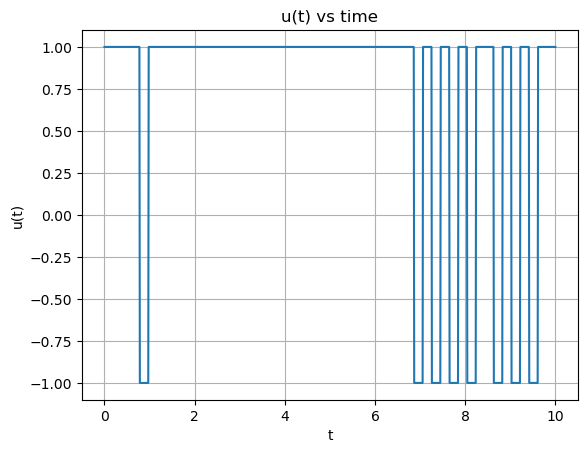

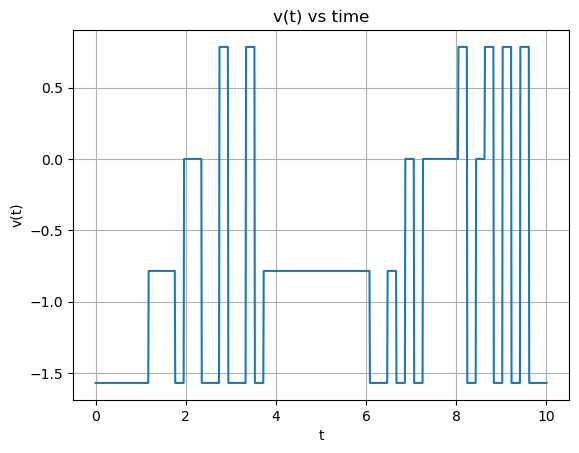

In [35]:
us=[2*(0.5-i%2) for i in u_t]
vs=[(1-i//2)*np.pi/4 for i in u_t]

u=[]
v=[]
for i in range(len(us)):
    for j in range(20):
        u.append(us[i])
        v.append(vs[i])
        
x = np.linspace(0, T, (N+1)*20)
plt.plot(x, u)
plt.xlabel('t')
plt.ylabel('u(t)')
plt.title("u(t) vs time")
plt.grid()
plt.show()

x = np.linspace(0, T, (N+1)*20)
plt.plot(x, v)
plt.xlabel('t')
plt.ylabel('v(t)')
plt.title("v(t) vs time")
plt.grid()
plt.show()

## Last Trajectory


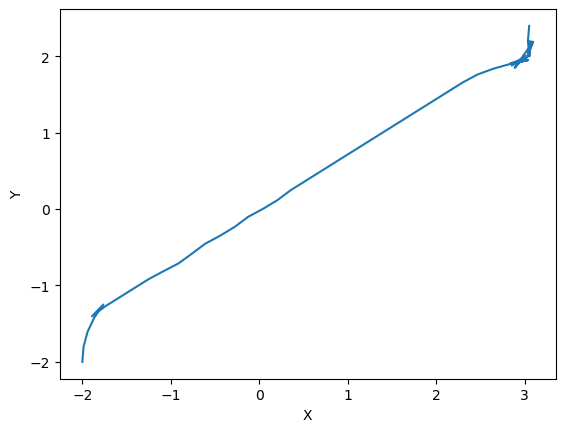

In [36]:
obs=np.array(observation_t)
obs=obs[:,[0,1]]
plt.plot(obs[:,0],obs[:,1])
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

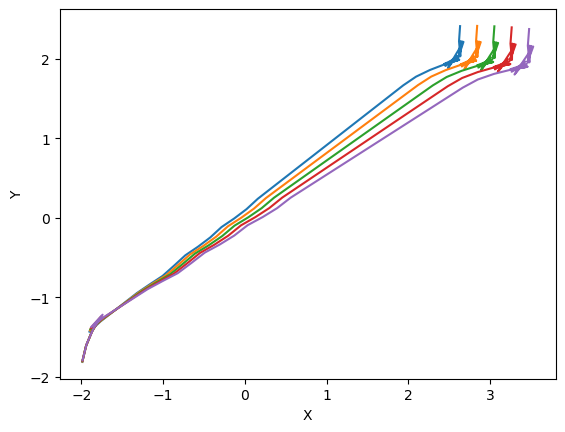

2.469535932599073


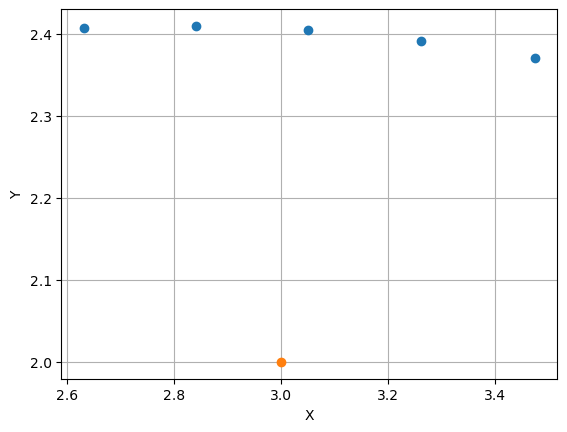

In [37]:
pos=[]
for i in range(num_system):
    obs=np.array(position_t[i])
    obs=obs[:,[0,1]]
    plt.plot(obs[:,0],obs[:,1])
    pos.append(obs[-1])
plt.xlabel('X')
plt.ylabel('Y')
plt.show()
print(reward_raw(np.array(pos)))

cord_x=[]
cord_y=[]
for i in range(num_system):
    cord_x.append(pos[i][0])
    cord_y.append(pos[i][1])
plt.plot(np.array(cord_x),np.array(cord_y), 'o')
plt.plot(np.array([3]),np.array([2]), 'o')
#plt.plot(obs[-1,0],obs[-1,1])
plt.xlabel('X')
plt.ylabel('Y')
plt.grid()
plt.show()


## Best Trajectory

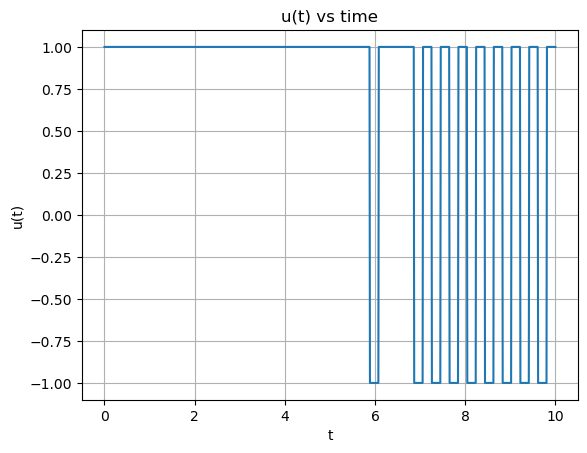

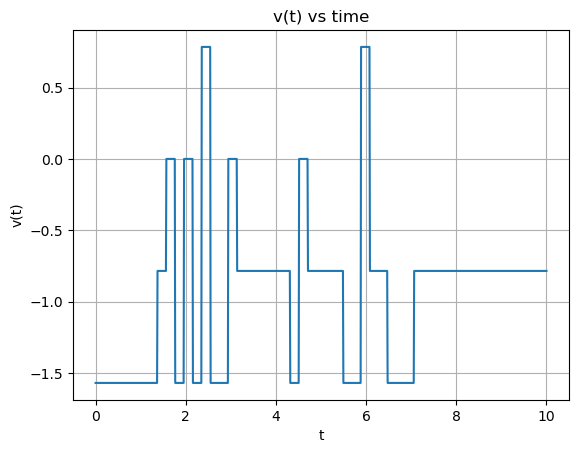

In [38]:
us=[2*(0.5-i%2) for i in best_u]
vs=[(1-i//2)*np.pi/4 for i in best_u]

u=[]
v=[]
for i in range(len(us)):
    for j in range(20):
        u.append(us[i])
        v.append(vs[i])

x = np.linspace(0, T, (N+1)*20)
plt.plot(x, u)
plt.xlabel('t')
plt.ylabel('u(t)')
plt.title("u(t) vs time")
plt.grid()
plt.show()

x = np.linspace(0, T, (N+1)*20)
plt.plot(x, v)
plt.xlabel('t')
plt.ylabel('v(t)')
plt.title("v(t) vs time")
plt.grid()
plt.show()

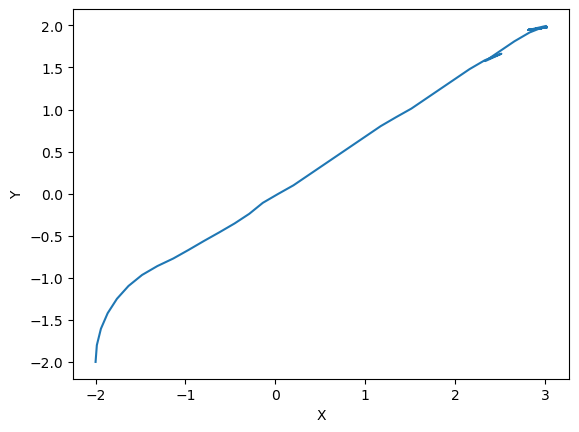

In [39]:
obs=np.array(best_obs)
obs=obs[:,[0,1]]
plt.plot(obs[:,0],obs[:,1])
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

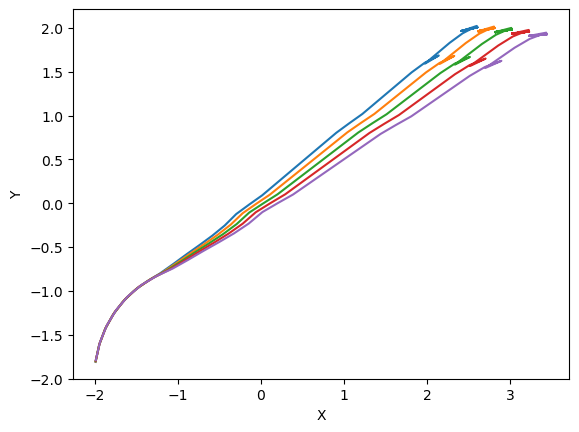

1.2808024494229882


In [40]:
pos=[]
for i in range(num_system):
    obs=np.array(best_pos[i])
    obs=obs[:,[0,1]]
    plt.plot(obs[:,0],obs[:,1])
    pos.append(obs[-1])
plt.xlabel('X')
plt.ylabel('Y')
plt.show()
print(reward_raw(np.array(pos)))

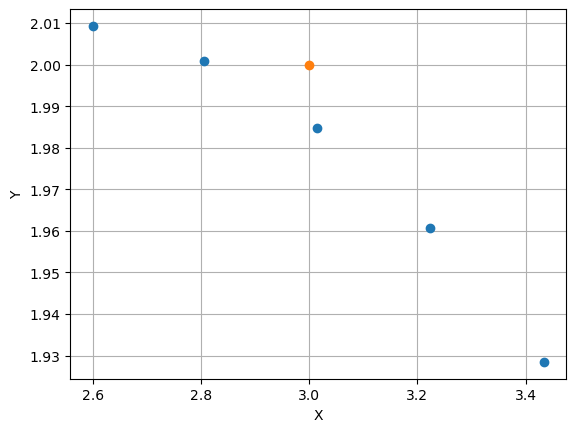

In [41]:
pos=[]
for i in range(num_system):
    obs=np.array(best_pos[i])
    obs=obs[:,[0,1]]
    #plt.plot(obs[:,0],obs[:,1])
    pos.append(obs[-1])

cord_x=[]
cord_y=[]
for i in range(num_system):
    cord_x.append(pos[i][0])
    cord_y.append(pos[i][1])
plt.plot(np.array(cord_x),np.array(cord_y), 'o')
plt.plot(np.array([3]),np.array([2]), 'o')
#plt.plot(obs[-1,0],obs[-1,1])
plt.xlabel('X')
plt.ylabel('Y')
plt.grid()
plt.show()

## Pure Exploitation Trajectory

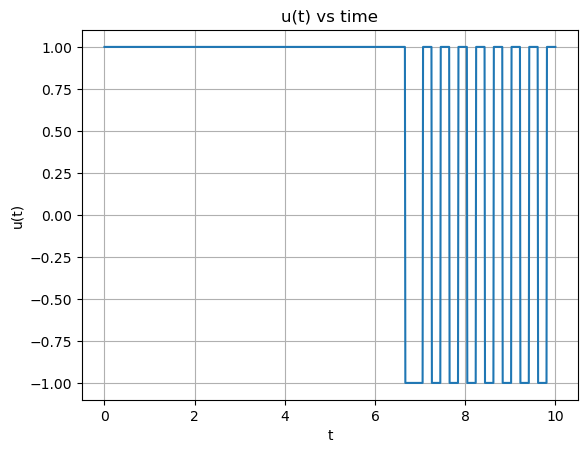

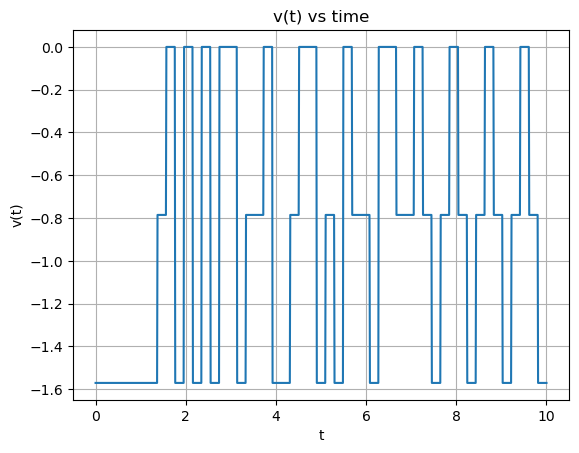

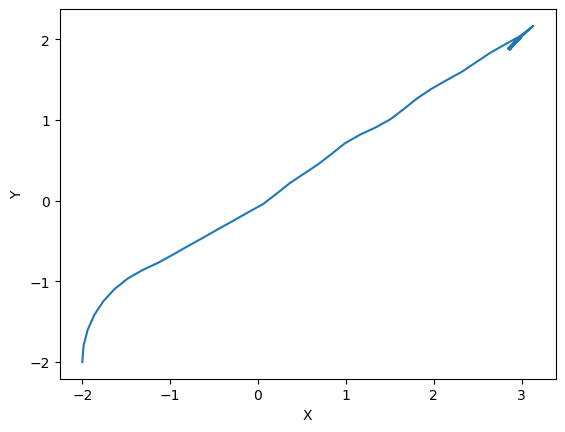

In [42]:
position=np.array([[-2,-2,np.pi/2] for _ in range(num_system)])
observation=observe(position)
u_t=[]
observation_t=[observation]
position_t=[[] for i in range(num_system)]

for time in range(N+1):           
    
    #print(candidates_u)
    u_k = decide_u_exploitation(gpr_list[time],flags,observation)
    position_new = next_step(position,action_set[u_k])
    observation_new = observe(position_new)
    r = reward(observation_new)
    '''
    if explo:
        history_su[u_k] = np.concatenate((history_su[u_k], observation.reshape(-1,5)))
        history_r[u_k] = np.concatenate((history_r[u_k],np.array([r])))
    '''
    observation=observation_new
    position=position_new
    u_t.append(u_k)
    observation_t.append(observation)
    for i in range(num_system):
        position_t[i].append(position[i])
    '''
    if time%((N+1)//3+1)==0:
        for i in range(6):
            gpr_list[i]=GaussianProcessRegressor(alpha=1e-8).fit(history_su[i], history_r[i].reshape(-1,1))
    '''
    
us=[2*(0.5-i%2) for i in u_t]
vs=[(1-i//2)*np.pi/4 for i in u_t]

u=[]
v=[]
for i in range(len(us)):
    for j in range(20):
        u.append(us[i])
        v.append(vs[i])
    

x = np.linspace(0, T, (N+1)*20)
plt.plot(x, u)
plt.xlabel('t')
plt.ylabel('u(t)')
plt.title("u(t) vs time")
plt.grid()
plt.show()

x = np.linspace(0, T, (N+1)*20)
plt.plot(x, v)
plt.xlabel('t')
plt.ylabel('v(t)')
plt.title("v(t) vs time")
plt.grid()
plt.show()

obs=np.array(observation_t)
obs=obs[:,[0,1]]
plt.plot(obs[:,0],obs[:,1])
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

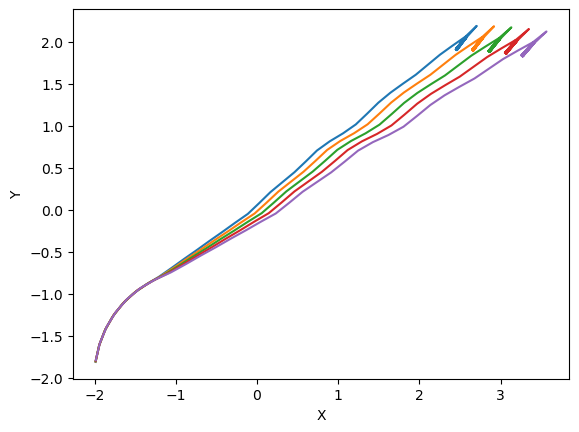

1.294686320970946


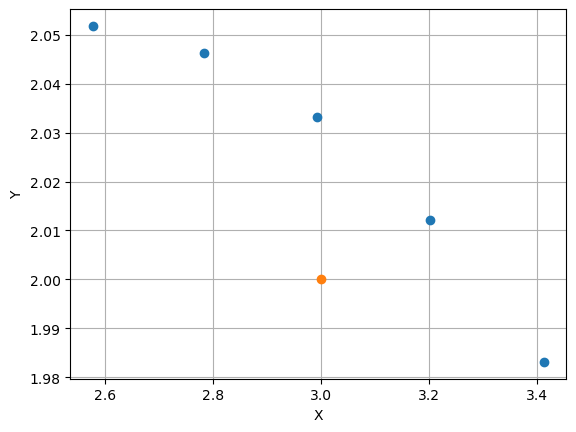

In [43]:
pos=[]
for i in range(num_system):
    obs=np.array(position_t[i])
    obs=obs[:,[0,1]]
    plt.plot(obs[:,0],obs[:,1])
    pos.append(obs[-1])
plt.xlabel('X')
plt.ylabel('Y')
plt.show()
print(reward_raw(position))

cord_x=[]
cord_y=[]
for i in range(num_system):
    cord_x.append(pos[i][0])
    cord_y.append(pos[i][1])
plt.plot(np.array(cord_x),np.array(cord_y), 'o')
plt.plot(np.array([3]),np.array([2]), 'o')
#plt.plot(obs[-1,0],obs[-1,1])
plt.xlabel('X')
plt.ylabel('Y')
plt.grid()
plt.show()